In [ ]:
import copy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.act2 = nn.ReLU()

    self.pool = nn.MaxPool2d(2)
    

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.act2(x)

    x = self.pool(x)
    return x


class LinearBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.linear = nn.Linear(in_channels, out_channels)
    self.bn = nn.BatchNorm1d(out_channels)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.linear(x)
    x = self.bn(x)
    x = self.act(x)
    return x

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = ConvBlock(3, 32, 3)
    self.conv2 = ConvBlock(32, 64, 3)
    self.conv3 = ConvBlock(64, 128, 3)
    self.conv4 = ConvBlock(128, 128, 3)
    self.linear1 = LinearBlock(128 * 2 * 2, 256)
    self.linear2 = LinearBlock(256, 256)
    self.out_linear = nn.Linear(256, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.out_linear(x)
    return x

def create_net():
  net = ConvNet()
  return net

In [ ]:
def calc_accuracy(trues, logits):
  preds = np.argmax(logits, axis=1)
  return (trues == preds).mean()
  
def train_epoch(net, dl, criterion, optimizer, device='cpu'):
  net.train()

  losses = list()
  for batch in dl:
    images, trues = batch

    images = images.to(device)
    trues = trues.to(device)

    logits = net(images)  

    loss = criterion(logits, trues)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  return losses


def inference_dl(net, dl):
  net.eval()
  all_trues = list()
  all_logits = list()
  with torch.no_grad():
    for batch in dl:
      images, trues = batch
      images = images.to(device)
      logits = net(images)

      all_trues.append(trues)
      all_logits.append(logits)
      
  all_trues = torch.cat(all_trues)
  all_logits = torch.cat(all_logits)

  return all_trues, all_logits

In [ ]:
batch_size = 128
num_workers = 0
lr = 1e-3
num_epochs = 9
device = 'cpu'

In [ ]:
train_ds = datasets.CIFAR10('../data', train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.CIFAR10('../data', train=False, download=True, transform=transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

net = create_net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


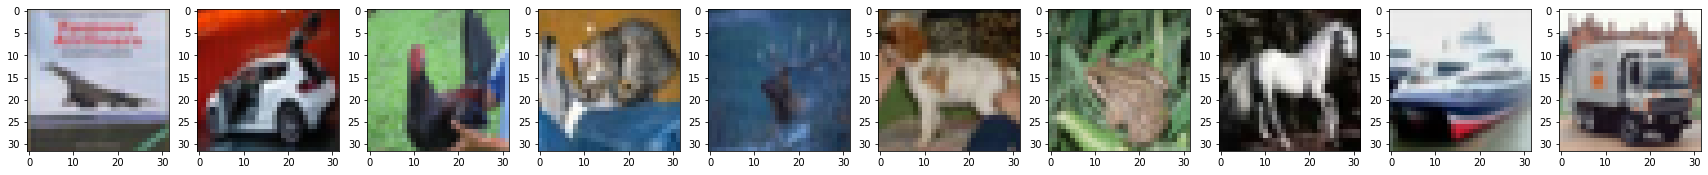

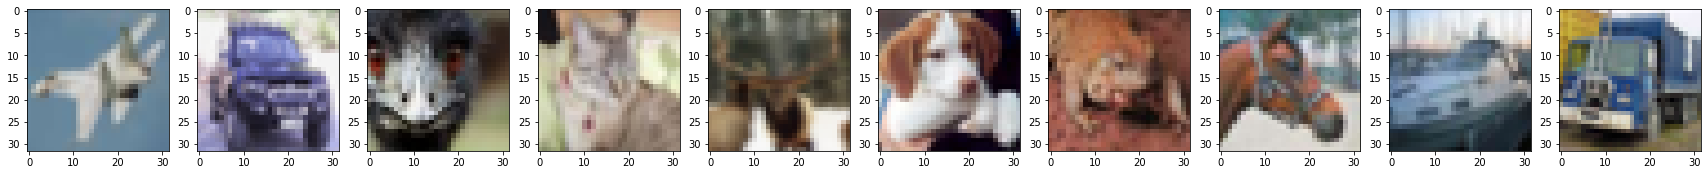

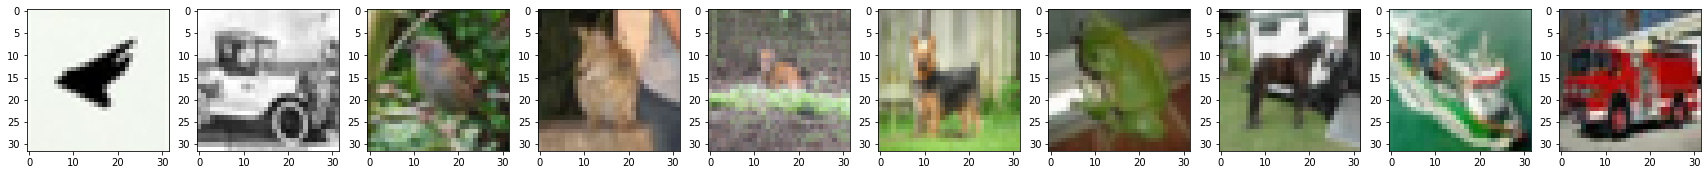

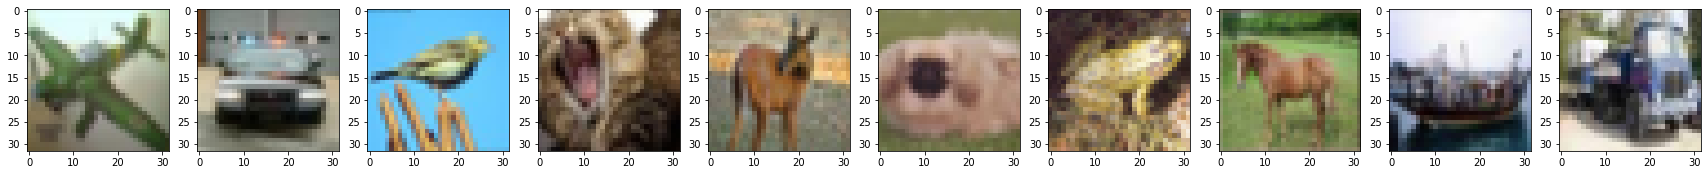

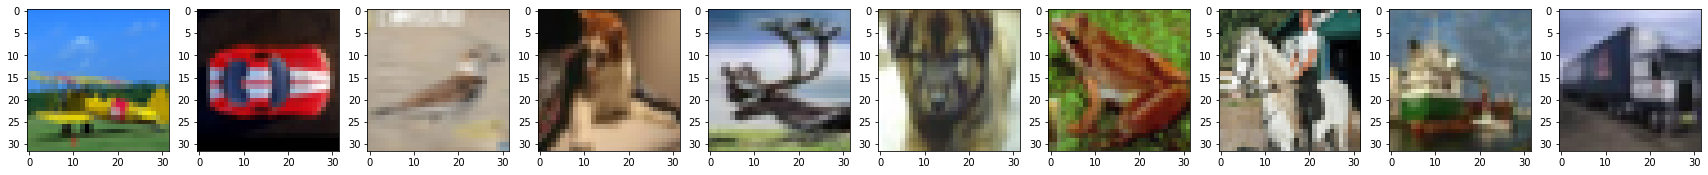

In [ ]:
for i in range(5):
  plt.figure(figsize=(30, 3))
  for class_num in range(10):
    plt.subplot(1, 10, class_num+1)
    index = np.where(np.array(test_ds.targets) == class_num)[0][i]
    image = test_ds.data[index]
    plt.imshow(image)
  plt.show()

In [ ]:
valid_accuracy = list()
train_losses = list()
data = list()

print('Epoch:', -1)
trues, logits = inference_dl(net, test_dl)

trues = trues.cpu().numpy()
logits = logits.detach().cpu().numpy()

accuracy = calc_accuracy(trues, logits)
valid_accuracy.append(accuracy)

print('Train loss:', 0)
print('Valid accuracy:', accuracy)

data.append((trues, logits))


for epoch in range(num_epochs):

  print('Epoch:', epoch)

  train_eposc_losses = train_epoch(net, train_dl, criterion=criterion, optimizer=optimizer)
  train_losses += train_eposc_losses

  trues, logits = inference_dl(net, test_dl)

  trues = trues.cpu().numpy()
  logits = logits.detach().cpu().numpy()

  accuracy = calc_accuracy(trues, logits)
  valid_accuracy.append(accuracy)

  print('Train loss:', np.mean(train_eposc_losses))
  print('Valid accuracy:', accuracy)

  data.append((trues, logits))


Epoch: -1
Train loss: 0
Valid accuracy: 0.1
Epoch: 0


In [ ]:
plt.figure(figsize=(30,5 ))
plt.plot(train_losses)
plt.grid()
plt.show()

plt.figure(figsize=(30,5 ))
plt.plot(valid_accuracy)
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

trues = data[-1][0]
preds = np.argmax(data[-1][1], axis=1)

cn = confusion_matrix(trues, preds)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cn).plot(ax=ax)
plt.show()


In [ ]:
logits = data[-1][1]
trues = data[-1][0]

plt.figure(figsize=(20, 10))
plt.hist(logits.flatten(), bins=100)
plt.grid()
plt.show()

In [ ]:
pos = list()
neg = list()
for i in range(logits.shape[0]):
  pos.append(logits[i, trues[i]])
  mask = np.array([j != trues[i] for j in range(10)])
  neg += list(logits[i][mask])

plt.figure(figsize=(20, 10))
plt.hist(pos, bins=100, alpha=0.5, color='green')
plt.hist(neg, bins=100, alpha=0.5, color='red')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve


def to_binary(trues, logits, class_num):
  bin_trues = trues == class_num
  bin_logits = logits[:, class_num]
  return bin_trues, bin_logits

def remove_part(trues, logits, fraq=0.5):
  neg_mask = trues == 0
  neg_trues = trues[neg_mask]
  neg_logits = logits[neg_mask]

  pos_mask = (trues == 1) & (np.random.random(size=trues.shape) < fraq)
  pos_trues = trues[pos_mask]
  pos_logits = logits[pos_mask]

  trues = np.concatenate([neg_trues, pos_trues])
  logits = np.concatenate([neg_logits, pos_logits], axis=0)

  return trues, logits

def binary_accuracy(trues, logits, threshold=0.0):
  preds = logits > threshold
  return (trues == preds).mean()

def roc_auc(trues, logits):
  return roc_auc_score(trues, logits)

def ap(trues, logits):
  return average_precision_score(trues, logits)


def find_threshold_f1(trues, logits, eps=1e-9):
    precision, recall, thresholds = precision_recall_curve(trues, logits)
    f1_scores = 2 * precision * recall / (precision + recall + eps)
    threshold = float(thresholds[np.argmax(f1_scores)])  
    return threshold



def calc_metrics(trues, logits):

  class_num = 2
  bin_trues, bin_logits = to_binary(trues, logits, class_num)

  bin_trues, bin_logits = remove_part(bin_trues, bin_logits, fraq=0.1)

  threshold = find_threshold_f1(bin_trues, bin_logits, eps=1e-9)
  print('Best f1 threshold:', threshold)

  result = dict()
  result['accuracy'] = calc_accuracy(trues, logits)
  result[f'acc_{class_num}_th_0'] = binary_accuracy(bin_trues, bin_logits, threshold=0.0)
  result[f'acc_{class_num}_th_opt'] = binary_accuracy(bin_trues, bin_logits, threshold=threshold)
  result[f'rocauc_{class_num}'] = roc_auc(bin_trues, bin_logits)
  result[f'ap_{class_num}'] = ap(bin_trues, bin_logits)

  #result.update(classification_metrics(bin_trues, bin_logits > threshold))

  return result

In [ ]:
all_metrics = list()
for i in range(num_epochs):
  trues, logits = data[i]
  metrics = calc_metrics(trues, logits)
  all_metrics.append(metrics)

all_metrics = pd.DataFrame(all_metrics).reset_index(drop=True)

all_metrics.plot(figsize=(30,5))
plt.grid()
plt.show()

In [ ]:
all_metrics

In [ ]:
def classification_metrics(trues, preds, eps=1e-9):   
    
    trues = np.array(trues) > 0.5
    preds = np.array(preds) > 0.5
           
    tp = (trues & preds).sum()
    tn = (~trues & ~preds).sum()
    fp = (~trues & preds).sum()
    fn = (trues & ~preds).sum()
    
    result = dict()
    result['tp'] = tp
    result['tn'] = tn
    result['fp'] = fp
    result['fn'] = fn
    
    result['accuracy'] = (trues == preds).mean()
    
    result['recall'] = tp / (tp + fn + eps)
    result['precision'] = tp / (tp + fp + eps)
    result['sensitivity'] = tp / (tp + fn + eps)
    result['specificity'] = tn / (tn + fp + eps)
    result['ppv'] = tp / (tp + fp + eps)
    result['npv'] = tn / (tn + fn + eps)
    
    result['f1'] = 2 * result['recall'] * result['precision'] / (result['recall'] + result['precision'] + eps)
    result['ss'] = 2 * result['sensitivity'] * result['specificity'] / (result['sensitivity'] + result['specificity'] + eps)
    
    result['trues_sum']  = int(trues.sum())
    result['trues_percent'] = result['trues_sum'] / trues.shape[0]
    
    result['preds_sum'] = int(preds.sum())
    result['preds_percent'] = result['preds_sum'] / preds.shape[0]
    
    result['count'] = trues.shape[0]
    return result

In [ ]:
all_metrics